In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# LOADING DATA

In [5]:
df = pd.read_csv(r"C:\Users\sansk\Downloads\marketing_campaign.csv",sep="\t")

In [6]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
len(df)

2240

# DATA CLEANING

In this section

1)Data Cleaning
2}Feature Engineering
In order to, get a full grasp of what steps should I be taking to clean the dataset. Let us have a look at the information in data.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

From the above output, we can conclude and note that:

1)There are missing values in income
2)Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime
3)There are some categorical features in our data frame; as there are some features in dtype: object). 
So we will need to encode them into numeric forms later.
First of all, for the missing values, I am simply going to drop the rows that have missing income values.

In [9]:
#To remove the NA values
df = df.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(df))

The total number of data-points after removing the rows with missing values are: 2216


In the next step, I am going to create a feature out of "Dt_Customer" that indicates the number of days a customer is registered in the firm's database. However, 
in order to keep it simple,
I am taking this value relative to the most recent customer in the record.

Thus to get the values I must check the newest and oldest recorded dates

In [10]:
df["Dt_Customer"] 

0       04-09-2012
1       08-03-2014
2       21-08-2013
3       10-02-2014
4       19-01-2014
           ...    
2235    13-06-2013
2236    10-06-2014
2237    25-01-2014
2238    24-01-2014
2239    15-10-2012
Name: Dt_Customer, Length: 2216, dtype: object

In [11]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


Creating a feature ("Customer_For") of the number of days the customers started to shop in the store relative to the last recorded date

In [12]:
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

Now we will be exploring the unique values in the categorical features to get a clear idea of the data

In [14]:
 #get a clear idea of the data.

print("Total categories in the feature Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", df["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In the next bit, I will be performing the following steps to engineer some new features:

1)Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.
2)Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.
3)Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.
4)Create a feature "Children" to indicate total children in a household that is, kids and teenagers.
5)To get further clarity of household, Creating feature indicating "Family_Size"
6)Create a feature "Is_Parent" to indicate parenthood status
7)Lastly, I will create three categories in the "Education" by simplifying its value counts.
8)Dropping some of the redundant features

In [15]:
#Feature Engineering
#Age of customer today 
df["Age"] = 2021-df["Year_Birth"]

#Total spendings on various items
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

#Deriving living situation by marital status"Alone"
df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)

Now that we have some new features let's have a look at the data's stats

In [16]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000



The above stats show some discrepancies in mean Income and Age and max Income and age.

Do note that max-age is 128 years, As I calculated the age that would be today (i.e. 2021) and the data is old.

I must take a look at the broader view of the data. I will plot some of the selected features.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 576x396 with 0 Axes>

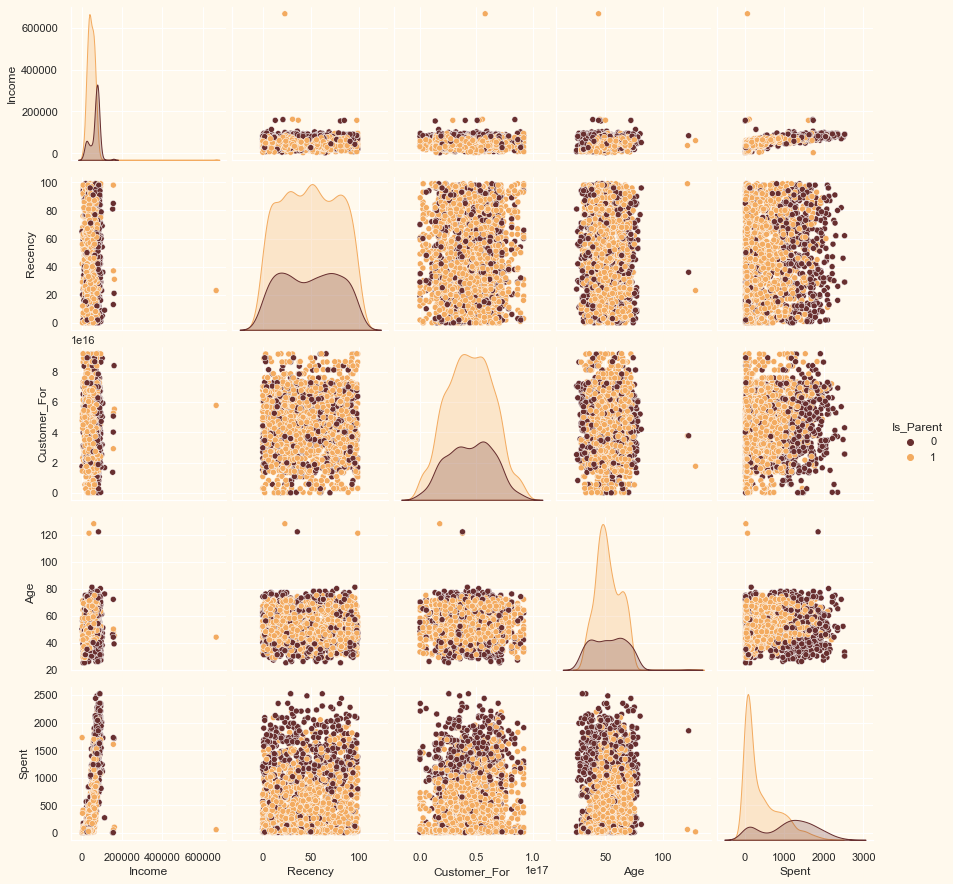

In [17]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

Clearly, there are a few outliers in the Income and Age features. I will be deleting the outliers in the data.

In [19]:
#Dropping the outliers by setting a cap on Age and income. 
data = df[(df["Age"]<90)]
data = df[(df["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2215


Next, let us look at the correlation amongst the features. (Excluding the categorical attributes at this point)



<AxesSubplot:>

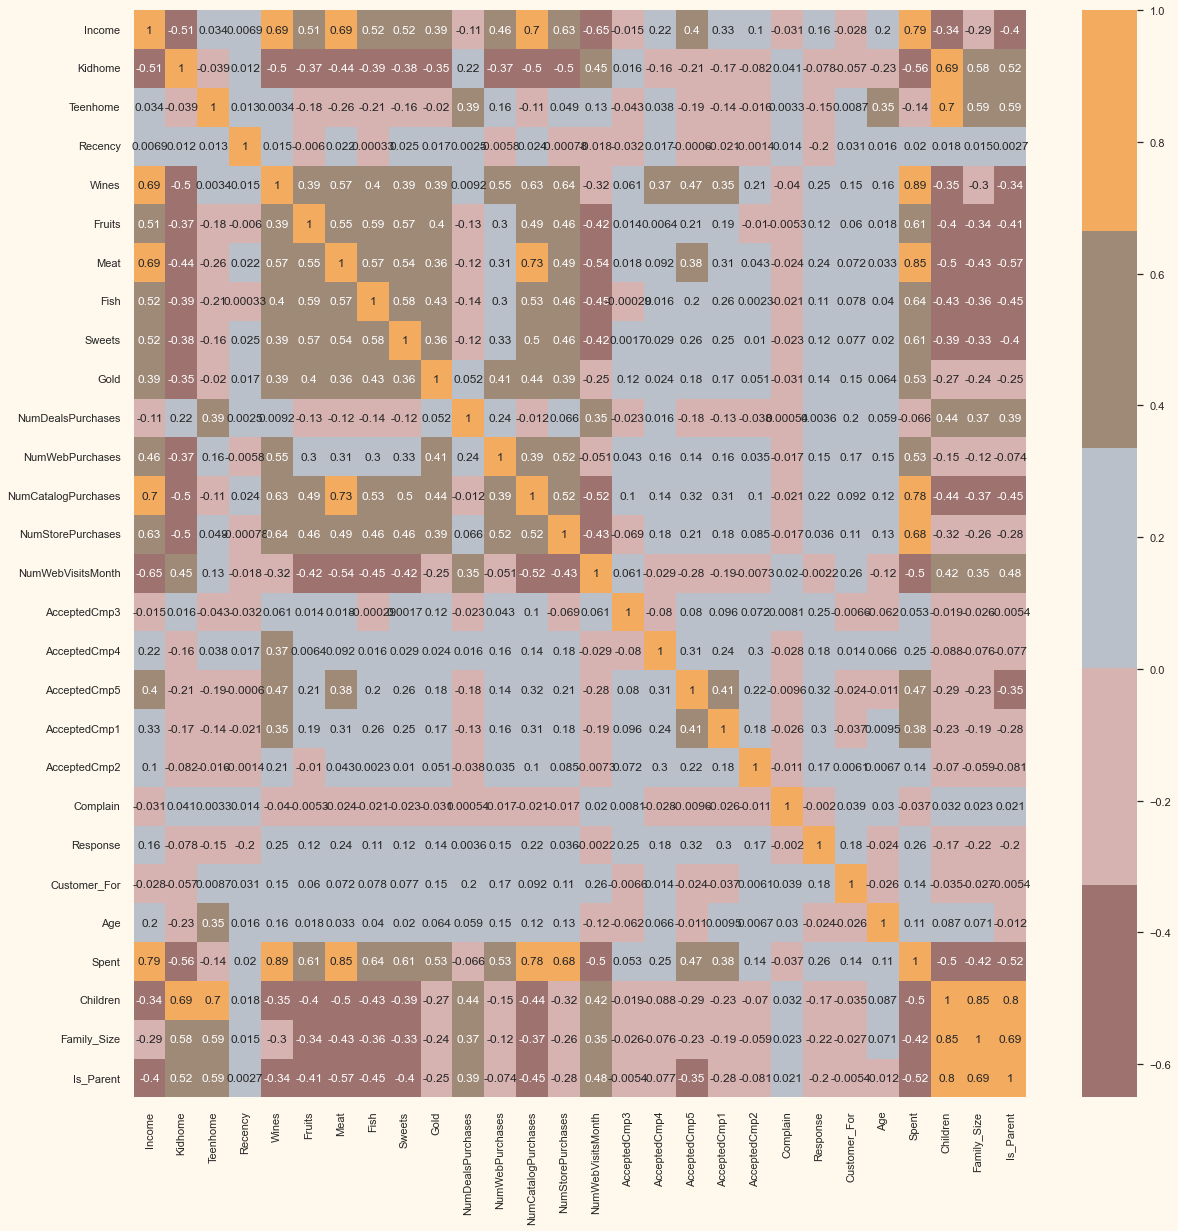

In [20]:
#correlation matrix
corrmat= data.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

The data is quite clean and the new features have been included. 
I will proceed to the next step. That is, preprocessing the data.

# DATA PREPROCESSING

In this section, I will be preprocessing the data to perform clustering operations.

The following steps are applied to preprocess the data:

1)Label encoding the categorical features
2)Scaling the features using the standard scaler
3)Creating a subset dataframe for dimensionality reduction

In [21]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [24]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")


All features are now numerical


In [25]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [26]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.894550,0.286604,-0.822585,-0.929363,0.310113,0.977779,1.548973,1.689714,2.453932,1.484340,...,2.504074,-0.554500,0.693215,1.974933,0.986016,1.675011,-1.348357,-1.264487,-1.758153,-1.580889
1,-0.894550,-0.261407,1.040427,0.908618,-0.380899,-0.872375,-0.637338,-0.718196,-0.651178,-0.634081,...,-0.571253,-1.169839,-0.131420,-1.664631,1.236344,-0.962727,-1.348357,1.405522,0.450131,0.632555
2,-0.894550,0.912723,-0.822585,-0.929363,-0.795506,0.358096,0.568903,-0.178646,1.339745,-0.147087,...,-0.229550,1.291518,-0.543738,-0.171808,0.318476,0.279830,0.741643,-1.264487,-0.654011,-1.580889
3,-0.894550,-1.176680,1.040427,-0.929363,-0.795506,-0.872375,-0.561948,-0.655768,-0.505056,-0.585381,...,-0.912956,-0.554500,0.280897,-1.922757,-1.266933,-0.919594,0.741643,0.070517,0.450131,0.632555
4,0.568839,0.293806,1.040427,-0.929363,1.553934,-0.392047,0.418123,-0.218777,0.152497,-0.000989,...,0.112153,0.060839,-0.131420,-0.821423,-1.016605,-0.307440,0.741643,0.070517,0.450131,0.632555


In [27]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.894550,0.286604,-0.822585,-0.929363,0.310113,0.977779,1.548973,1.689714,2.453932,1.484340,...,2.504074,-0.554500,0.693215,1.974933,0.986016,1.675011,-1.348357,-1.264487,-1.758153,-1.580889
1,-0.894550,-0.261407,1.040427,0.908618,-0.380899,-0.872375,-0.637338,-0.718196,-0.651178,-0.634081,...,-0.571253,-1.169839,-0.131420,-1.664631,1.236344,-0.962727,-1.348357,1.405522,0.450131,0.632555
2,-0.894550,0.912723,-0.822585,-0.929363,-0.795506,0.358096,0.568903,-0.178646,1.339745,-0.147087,...,-0.229550,1.291518,-0.543738,-0.171808,0.318476,0.279830,0.741643,-1.264487,-0.654011,-1.580889
3,-0.894550,-1.176680,1.040427,-0.929363,-0.795506,-0.872375,-0.561948,-0.655768,-0.505056,-0.585381,...,-0.912956,-0.554500,0.280897,-1.922757,-1.266933,-0.919594,0.741643,0.070517,0.450131,0.632555
4,0.568839,0.293806,1.040427,-0.929363,1.553934,-0.392047,0.418123,-0.218777,0.152497,-0.000989,...,0.112153,0.060839,-0.131420,-0.821423,-1.016605,-0.307440,0.741643,0.070517,0.450131,0.632555


# DIMENSIONALITY REDUCTION

In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction on the selected features before putting them through a classifier.
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

Steps in this section:

1)Dimensionality reduction with PCA
2)Plotting the reduced dataframe

Dimensionality reduction with PCA

For this project, I will be reducing the dimensions to 3.

In [28]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2215.0,-5.252884e-17,2.878871,-5.969904,-2.536835,-0.781744,2.384980,7.441981
col2,2215.0,-5.112539e-18,1.704159,-4.305663,-1.321027,-0.160330,1.231766,6.136731
col3,2215.0,-6.295441e-17,1.222061,-3.507546,-0.827583,-0.020431,0.798334,6.619322


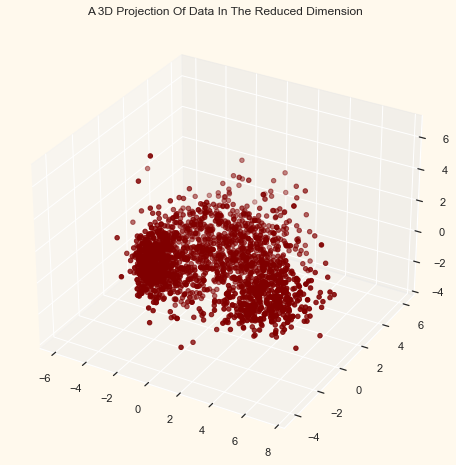

In [41]:

x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()


# CLUSTERING

Now that I have reduced the attributes to three dimensions, I will be performing clustering via Agglomerative clustering. Agglomerative clustering is a hierarchical clustering method. 
It involves merging examples until the desired number of clusters is achieved.

Steps involved in the Clustering

1)Elbow Method to determine the number of clusters to be formed

2)Clustering via Agglomerative Clustering

3)Examining the clusters formed via scatter plot

Elbow Method to determine the number of clusters to be formed:


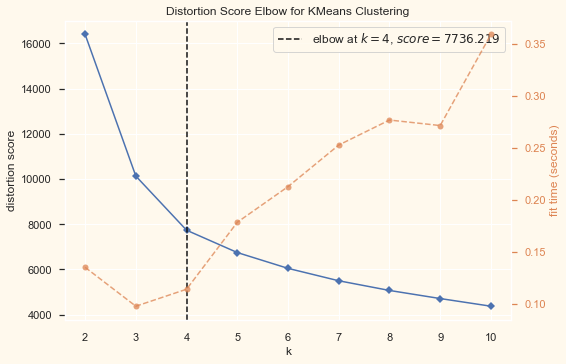

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

The above cell indicates that four will be an optimal number of clusters for this data. Next, we will be fitting the Agglomerative Clustering Model to get the final clusters

In [31]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

To examine the clusters formed let's have a look at the 3-D distribution of the clusters.

In [32]:
data["Clusters"]

0       3
1       1
2       3
3       2
4       1
       ..
2235    0
2236    0
2237    3
2238    0
2239    1
Name: Clusters, Length: 2215, dtype: int64

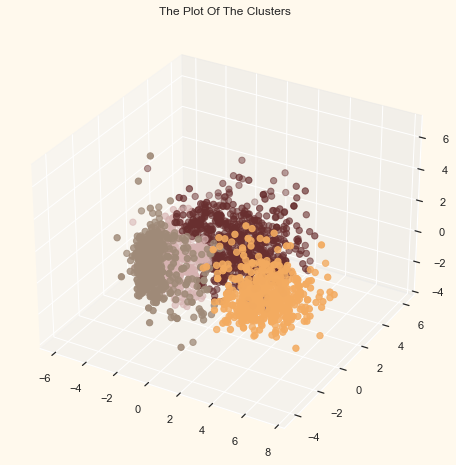

In [33]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

# EVALUATING MODELS

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. 
The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

Firstly, let us have a look at the group distribution of clustring

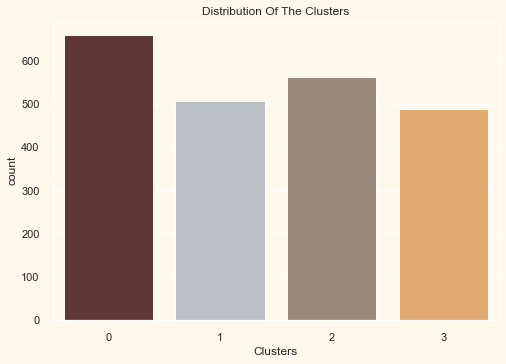

In [34]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

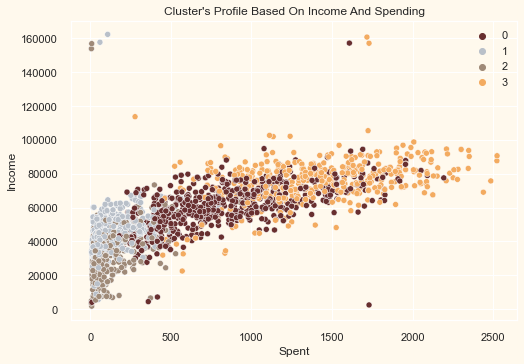

In [35]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Income vs spending plot shows the clusters pattern
1)group 0: high spending & average income
2)group 1: high spending & high income
3)group 2: low spending & low income
4)group 3: high spending & low income


Next, I will be looking at the detailed distribution of clusters as per the various products in the data. 
Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

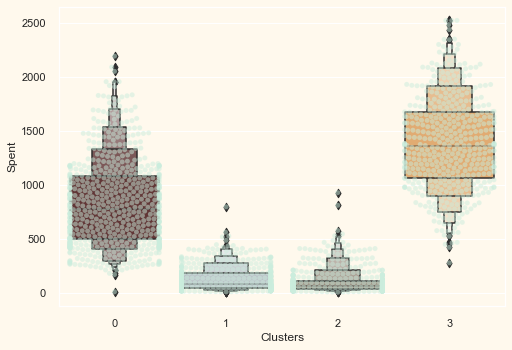

In [36]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

From the above plot, it can be clearly seen that cluster 1 is our biggest set of customers closely followed by cluster 0. 
We can explore what each cluster is spending on for the targeted marketing strategies.

Let us next explore how did our campaigns do in the past.

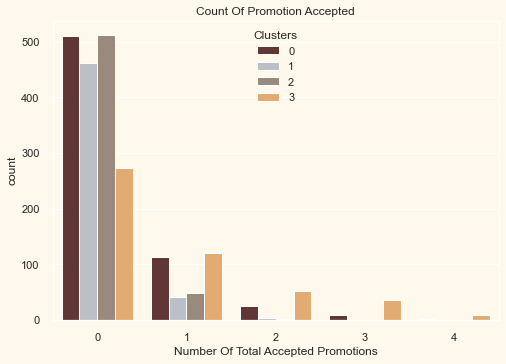

In [37]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. 
Moreover, no one part take in all 5 of them. 
Perhaps better-targeted and well-planned campaigns are required to boost sales.

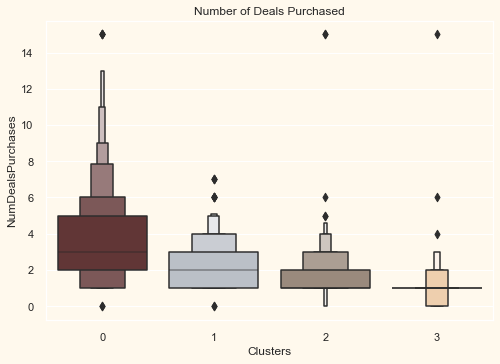

In [38]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. 
However, our star customers cluster 1 are not much into the deals.
Nothing seems to attract cluster 2 overwhelmingly

# PROFILING

Now that we have formed the clusters and looked at their purchasing habits. Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. On the basis of the outcomes, I will be arriving at the conclusions.

<Figure size 576x396 with 0 Axes>

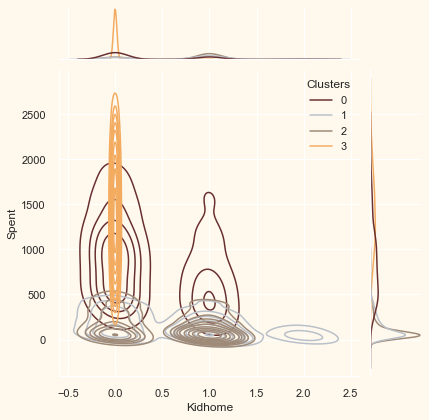

<Figure size 576x396 with 0 Axes>

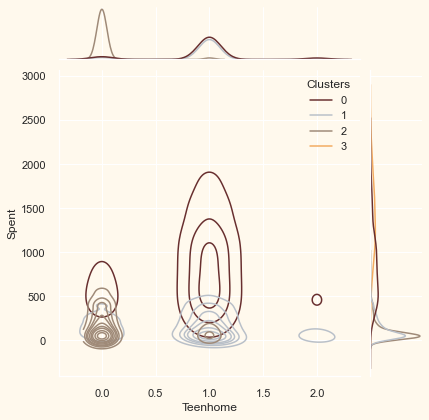

<Figure size 576x396 with 0 Axes>

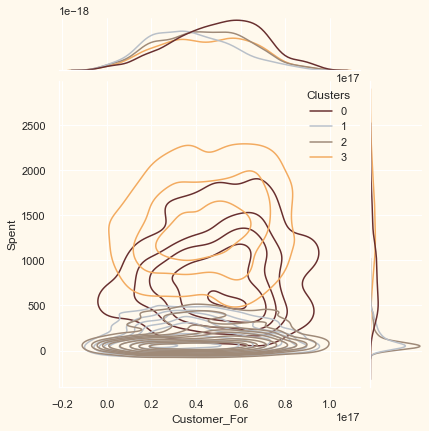

<Figure size 576x396 with 0 Axes>

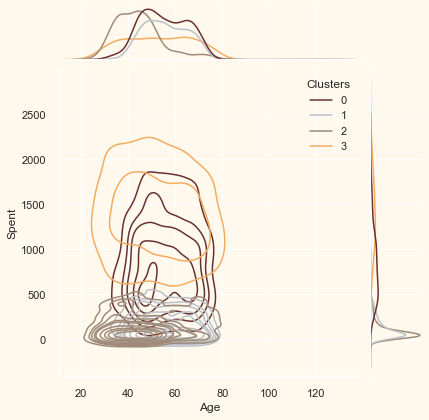

<Figure size 576x396 with 0 Axes>

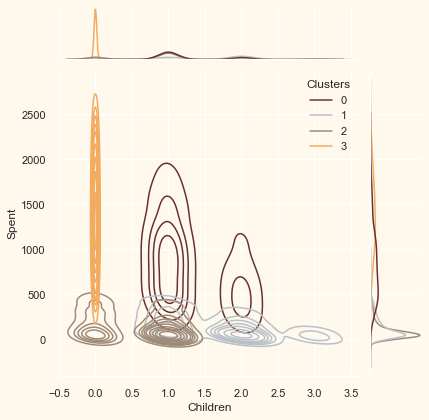

<Figure size 576x396 with 0 Axes>

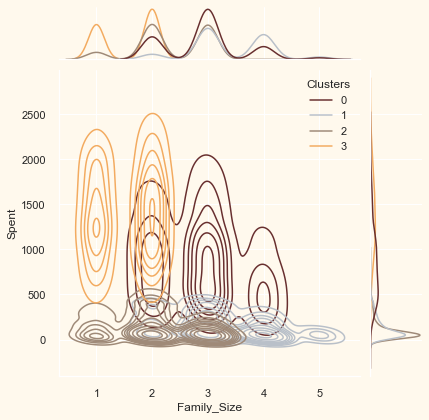

<Figure size 576x396 with 0 Axes>

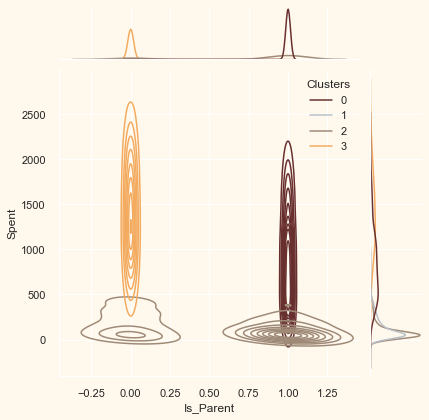

<Figure size 576x396 with 0 Axes>

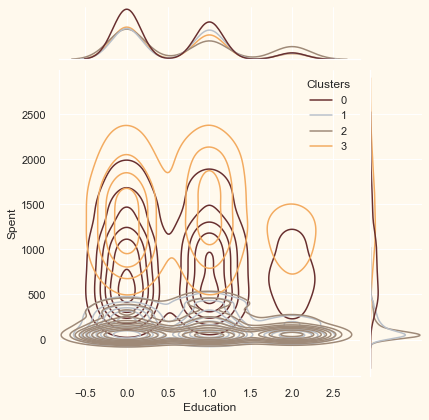

<Figure size 576x396 with 0 Axes>

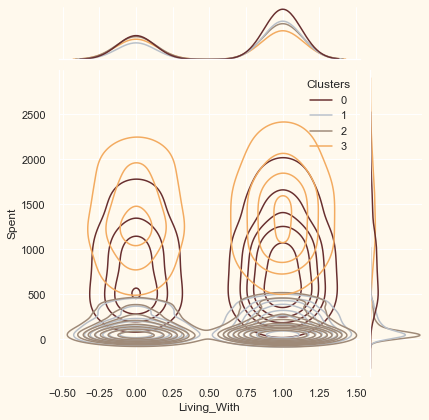

In [39]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

# CONCLUSION


In this project, I performed unsupervised clustering. I did use dimensionality reduction followed by agglomerative clustering. I came up with 4 clusters and further used them in profiling customers in clusters according to their family structures and income/spending. This can be used in planning better marketing strategies.